In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
from PIL import Image
from scipy.stats import spearmanr as spr
from tqdm import tqdm_notebook as tqdm_loop

In [2]:
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from captum.attr import Saliency, IntegratedGradients, LRP, GuidedBackprop, NoiseTunnel, GuidedGradCam, InputXGradient
from captum.attr import visualization as viz

In [4]:
sys.path.append("../attacks/")
from utils import get_expl, torch_to_image, load_image,  convert_relu_to_softplus, heatmap_to_image

In [5]:
sys.path.append("../../pytorch-cifar/models/")
from resnet import ResNet18, ResNet50
import resnet

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [7]:
data_mean = np.array([0.4914, 0.4822, 0.4465])
data_std = np.array([0.2023, 0.1994, 0.2010])

In [8]:
# models
model_standard = ResNet18()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = ResNet18()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)
######
model_adv_train = ResNet18()
model_adv_train.load_state_dict(torch.load("models/RN18_linf_8_model_only.pt")["net"])
model_adv_train = model_adv_train.eval().to(device)


In [9]:
# data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, 
                                          transform=transform_test)

test_loader = torch.utils.data.DataLoader(
        cifar_test,
        batch_size=8,
        shuffle=False
    )

Files already downloaded and verified


In [28]:
# images, labels = next(dataiter)

In [29]:
# a = np.random.randint(32)
# img = images[a].unsqueeze(0).to(device)
# img_label = labels[a]
# print(labels[a])
# plt.figure(figsize=(2,2))
# plt.imshow(torch_to_image(img, data_mean, data_std))
# plt.axis('off')
# plt.savefig("object_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [91]:
# dataiter = iter(test_loader)
images, labels = next(dataiter)
idx=np.random.randint(8)
img = images[idx].unsqueeze(dim=0).cuda()
img_label = labels[idx]

(-0.5, 31.5, 31.5, -0.5)

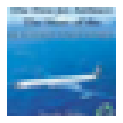

In [92]:
plt.figure(figsize=(2,2))
plt.imshow(torch_to_image(img, data_mean, data_std))
plt.axis("off")
# plt.savefig("plane_image_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [93]:
print(model_standard(img).argmax(), img_label)
print(model_adv_train(img).argmax(), img_label)

tensor(0, device='cuda:0') tensor(0)
tensor(8, device='cuda:0') tensor(0)


Text(0.5, 1.0, 'adversarial training')

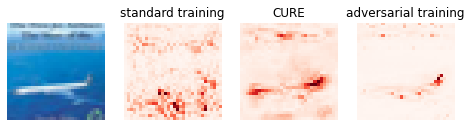

In [96]:
expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label)
expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label)

fig, ax = plt.subplots(1,4, figsize=(8,2))
ax[0].imshow(torch_to_image(img, data_mean, data_std))
viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(3,3), plt_fig_axis=(fig, ax[3]), use_pyplot=False)

for i in range(4):
    ax[i].axis('off')
ax[1].set_title("standard training")
ax[2].set_title("CURE")
ax[3].set_title("adversarial training")

### Gradient norm

In [15]:
standard_rn18_norms = []
cure_rn18_norms = []
adv_train_rn18_norms = []
i = 0
while i < 10:
    a = np.random.randint(32)
    x = images[a].unsqueeze(dim=0).to(device)
    x_label = labels[a]
    expl_standard_rn18 = get_expl(model_standard, x, "saliency", desired_index=x_label, abs_value=False).detach().cpu()
    standard_rn18_norms.append(torch.norm(expl_standard_rn18))
    expl_cure_rn_18 = get_expl(model_cure, x, "saliency", desired_index=x_label, abs_value=False).detach().cpu()
    cure_rn18_norms.append(torch.norm(expl_cure_rn_18))
    expl_adv_train_rn18 = get_expl(model_adv_train, x, "saliency", desired_index=x_label, abs_value=False).detach().cpu()
    adv_train_rn18_norms.append(torch.norm(expl_adv_train_rn18))
    ###
    del expl_standard_rn18
    del expl_cure_rn_18
    del expl_adv_train_rn18
    torch.cuda.empty_cache()
    i = i+1
    

In [16]:
print("standard RN18: ", np.mean(standard_rn18_norms))
print("CURE RN18: ", np.mean(cure_rn18_norms))
print("adv train RN18 ", np.mean(adv_train_rn18_norms))

standard RN18:  6.7747545
CURE RN18:  0.27284914
adv train RN18  0.32025152


### Cascade randomization of layers

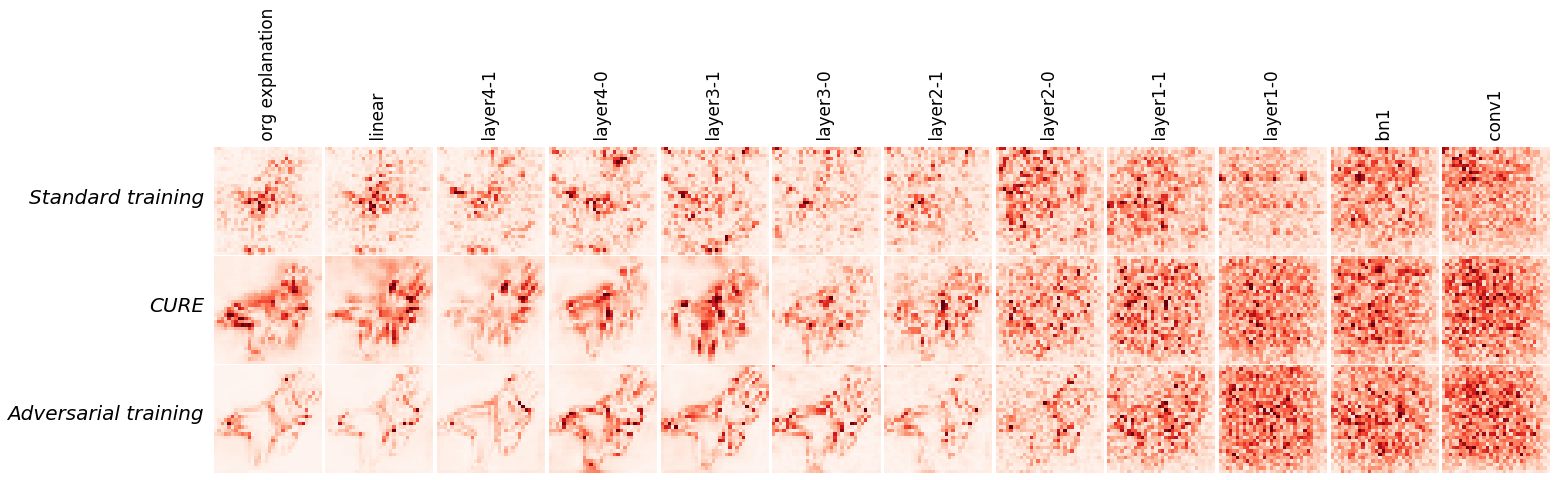

In [17]:
# cascade

layer_names = ["conv1", "bn1", 
              "layer1-0", "layer1-1",
              "layer2-0", "layer2-1",
              "layer3-0", "layer3-1",
              "layer4-0", "layer4-1",
              "linear", "org explanation"]
layer_names = layer_names[::-1]


expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label)
expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label)

fig, ax = plt.subplots(3, 12, figsize=(24, 6))
viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)



org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for child_name, child in model_standard.named_children():
    if isinstance(child, nn.Conv2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                org_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        org_layers_to_reinit.append(child)
    else:
        pass

org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label)

    viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)
############CURE####################
cure_layers_to_reinit = []

for child_name, child in model_cure.named_children():
    if isinstance(child, nn.Conv2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                cure_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        cure_layers_to_reinit.append(child)
    else:
        pass

cure_layers_to_reinit = cure_layers_to_reinit[::-1]

for i, l in enumerate(cure_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label)

    viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)

###########adversarial training####################
adv_train_layers_to_reinit = []

for child_name, child in model_adv_train.named_children():
    if isinstance(child, nn.Conv2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                adv_train_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        adv_train_layers_to_reinit.append(child)
    else:
        pass

adv_train_layers_to_reinit = adv_train_layers_to_reinit[::-1]

for i, l in enumerate(adv_train_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label)

    viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)

    
    
for i in range(12):
    ax[0, i].set_title(" " + layer_names[i], fontsize=17, rotation=90)
for i in range(3): 
    for j in range(12):
        ax[i,j].axis('off')
fig.text(0.12, 0.75, 'Standard training', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.5, 'CURE', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.25, 'Adversarial training', style = 'oblique', fontsize = 20, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### comparing with spr values
We run this on 100 examples and average the spr values.

In [22]:
np.random.seed(seed=93)
torch.random.manual_seed(seed=93)
torch.cuda.random.manual_seed(seed=93)
dataiter = iter(test_loader)

In [ ]:
spr_standard_all = []
spr_cure_all = []
spr_adv_train_all = []

for num_img in range(1000):
    # load image
    images, labels = next(dataiter)
    idx = np.random.randint(8)
    img = images[idx].unsqueeze(dim=0).cuda()
    img_label = labels[idx]
    if num_img==0:
        plt.figure(figsize=(2,2))
        plt.imshow(torch_to_image(img, data_mean, data_std))
        plt.axis("off")
    if num_img%100==0:
        print(img_label)
    # models
    model_standard = ResNet18()
    model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
    model_standard = model_standard.eval().to(device)
    ######
    model_cure = ResNet18()
    model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
    model_cure = model_cure.eval().to(device)
    ######
    model_adv_train = ResNet18()
    model_adv_train.load_state_dict(torch.load("models/RN18_linf_8_model_only.pt")["net"])
    model_adv_train = model_adv_train.eval().to(device)

    expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label).detach().cpu()
    expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label).detach().cpu()
    expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label).detach().cpu()
    torch.cuda.empty_cache()


    org_layers_to_reinit = []
    # softplus_layers_to_reinit = []

    for child_name, child in model_standard.named_children():
        if isinstance(child, nn.Conv2d):
            org_layers_to_reinit.append(child)
        elif isinstance(child, nn.BatchNorm2d):
            org_layers_to_reinit.append(child)
        elif isinstance(child, nn.Sequential):
            for c_name, c in child.named_children():
                if isinstance(c, resnet.BasicBlock):
                    org_layers_to_reinit.append(c)
        elif isinstance(child, nn.Linear):
            org_layers_to_reinit.append(child)
        else:
            pass

    org_layers_to_reinit = org_layers_to_reinit[::-1]

    # SPR VALUES
    spr_standard = [1.0]
    spr_cure = [1.0]
    spr_adv_train=[1.0]

    for i, l in enumerate(org_layers_to_reinit):
        if isinstance(l, nn.Conv2d):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            nn.init.constant_(l.bias, 0)
            nn.init.constant_(l.weight, 1)
            nn.init.constant_(l.running_mean, 0)
            nn.init.constant_(l.running_var, 1)
        elif isinstance(l, nn.Linear):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, resnet.BasicBlock):
            for c_name, c in l.named_children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
                elif isinstance(c, nn.BatchNorm2d):
                    nn.init.constant_(c.bias, 0)
                    nn.init.constant_(c.weight, 1)
                    nn.init.constant_(c.running_mean, 0)
                    nn.init.constant_(c.running_var, 1)

        expl_standard_rand = get_expl(model_standard, img, "saliency", desired_index=img_label).detach().cpu()
        spr_standard.append(spr(expl_standard.flatten(), expl_standard_rand.flatten())[0])
        del expl_standard_rand
        torch.cuda.empty_cache()


    ############CURE###########################

    cure_layers_to_reinit = []

    for child_name, child in model_cure.named_children():
        if isinstance(child, nn.Conv2d):
            cure_layers_to_reinit.append(child)
        elif isinstance(child, nn.BatchNorm2d):
            cure_layers_to_reinit.append(child)
        elif isinstance(child, nn.Sequential):
            for c_name, c in child.named_children():
                if isinstance(c, resnet.BasicBlock):
                    cure_layers_to_reinit.append(c)
        elif isinstance(child, nn.Linear):
            cure_layers_to_reinit.append(child)
        else:
            pass

    cure_layers_to_reinit = cure_layers_to_reinit[::-1]

    for i, l in enumerate(cure_layers_to_reinit):
        if isinstance(l, nn.Conv2d):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            nn.init.constant_(l.bias, 0)
            nn.init.constant_(l.weight, 1)
            nn.init.constant_(l.running_mean, 0)
            nn.init.constant_(l.running_var, 1)
        elif isinstance(l, nn.Linear):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, resnet.BasicBlock):
            for c_name, c in l.named_children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
                elif isinstance(c, nn.BatchNorm2d):
                    nn.init.constant_(c.bias, 0)
                    nn.init.constant_(c.weight, 1)
                    nn.init.constant_(c.running_mean, 0)
                    nn.init.constant_(c.running_var, 1)

        expl_cure_rand = get_expl(model_cure, img, "saliency", desired_index=img_label).detach().cpu()
        spr_cure.append(spr(expl_cure.flatten(), expl_cure_rand.flatten())[0])
        del expl_cure_rand
        torch.cuda.empty_cache()

    ###########adversarial training####################
    adv_train_layers_to_reinit = []

    for child_name, child in model_adv_train.named_children():
        if isinstance(child, nn.Conv2d):
            adv_train_layers_to_reinit.append(child)
        elif isinstance(child, nn.BatchNorm2d):
            adv_train_layers_to_reinit.append(child)
        elif isinstance(child, nn.Sequential):
            for c_name, c in child.named_children():
                if isinstance(c, resnet.BasicBlock):
                    adv_train_layers_to_reinit.append(c)
        elif isinstance(child, nn.Linear):
            adv_train_layers_to_reinit.append(child)
        else:
            pass

    adv_train_layers_to_reinit = adv_train_layers_to_reinit[::-1]

    for i, l in enumerate(adv_train_layers_to_reinit):
        if isinstance(l, nn.Conv2d):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, nn.BatchNorm2d):
            nn.init.constant_(l.bias, 0)
            nn.init.constant_(l.weight, 1)
            nn.init.constant_(l.running_mean, 0)
            nn.init.constant_(l.running_var, 1)
        elif isinstance(l, nn.Linear):
            nn.init.xavier_uniform_(l.weight)
        elif isinstance(l, resnet.BasicBlock):
            for c_name, c in l.named_children():
                if isinstance(c, nn.Conv2d):
                    nn.init.xavier_uniform_(c.weight)
                elif isinstance(c, nn.BatchNorm2d):
                    nn.init.constant_(c.bias, 0)
                    nn.init.constant_(c.weight, 1)
                    nn.init.constant_(c.running_mean, 0)
                    nn.init.constant_(c.running_var, 1)

        expl_adv_train_rand = get_expl(model_adv_train, img, "saliency", desired_index=img_label).detach().cpu()
        spr_adv_train.append(spr(expl_adv_train.flatten(), expl_adv_train_rand.flatten())[0])
        del expl_adv_train_rand
        torch.cuda.empty_cache()
        
    ########
    spr_standard_all.append(spr_standard)
    spr_cure_all.append(spr_cure)
    spr_adv_train_all.append(spr_adv_train)


tensor(6)
tensor(7)


In [24]:
np.mean(np.array(spr_standard_all), axis=0)

array([1.        , 0.41990124, 0.36879493, 0.29287783, 0.25692457,
       0.21311289, 0.19317778, 0.16674047, 0.14892671, 0.11596902,
       0.10007945, 0.10812907])

In [26]:
len(spr_standard_all)

1000

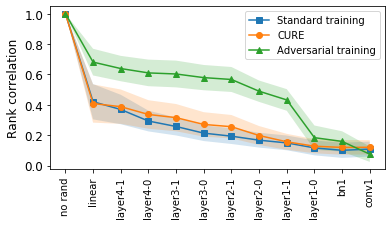

In [33]:
plt.figure(figsize=(6, 3))
plt.plot(np.mean(np.array(spr_standard_all), axis=0), label="Standard training", marker="s")
y = np.mean(np.array(spr_standard_all), axis=0)
error = np.std(np.array(spr_standard_all), axis=0)
plt.fill_between(range(12), y-error, y+error, alpha=0.2)
###
plt.plot(np.mean(np.array(spr_cure_all), axis=0), label="CURE", marker="o")
y = np.mean(np.array(spr_cure_all), axis=0)
error = np.std(np.array(spr_cure_all), axis=0)
plt.fill_between(range(12), y-error, y+error, alpha=0.2)
###
plt.plot(np.mean(np.array(spr_adv_train_all), axis=0), label="Adversarial training", marker="^")
y = np.mean(np.array(spr_adv_train_all), axis=0)
error = np.std(np.array(spr_adv_train_all), axis=0)
plt.fill_between(range(12), y-error, y+error, alpha=0.2)
plt.legend()
plt.xticks(range(12), ["no rand"] + layer_names[1:], rotation=90);
plt.yticks(fontsize=12)
plt.ylabel("Rank correlation", fontsize=12)
plt.savefig("spr_cascade_randomized_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

#### without absolute values

/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


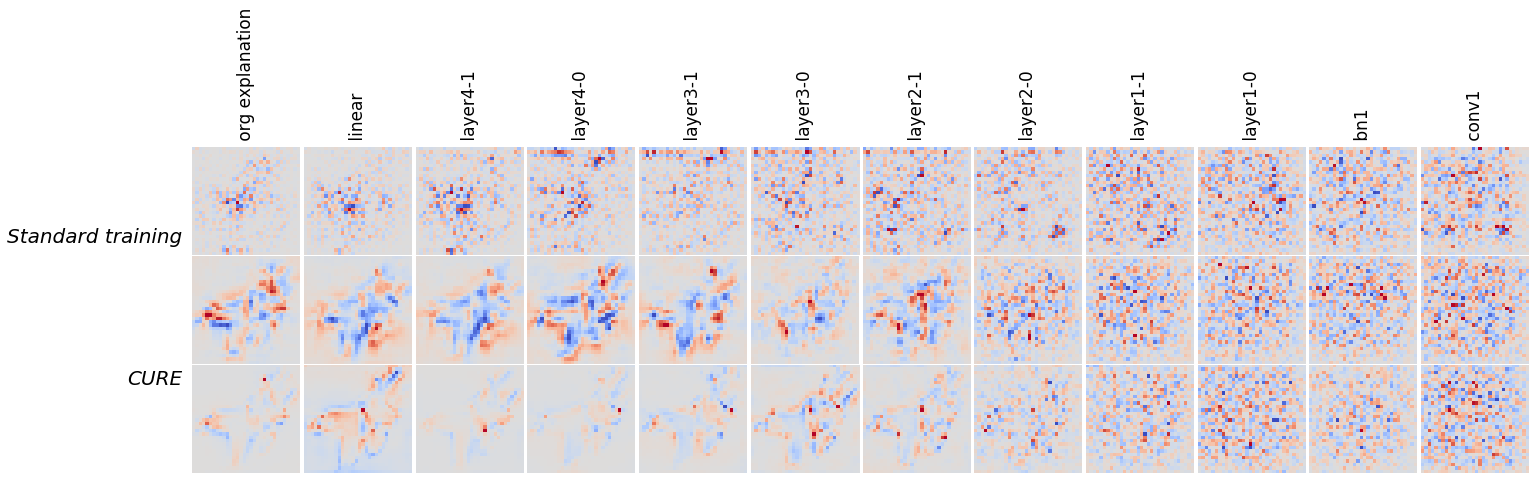

In [23]:
# cascade
# models
model_standard = ResNet18()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = ResNet18()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)
######
model_adv_train = ResNet18()
model_adv_train.load_state_dict(torch.load("models/RN18_linf_8_model_only.pt"))
model_adv_train = model_adv_train.eval().to(device)

layer_names = ["conv1", "bn1", 
              "layer1-0", "layer1-1",
              "layer2-0", "layer2-1",
              "layer3-0", "layer3-1",
              "layer4-0", "layer4-1",
              "linear", "org explanation"]
layer_names = layer_names[::-1]


expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label, abs_value=False)
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label, abs_value=False)
expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label, abs_value=False)

fig, ax = plt.subplots(3, 12, figsize=(24, 6))
viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, 0]), use_pyplot=False)

viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, 0]), use_pyplot=False)



org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for child_name, child in model_standard.named_children():
    if isinstance(child, nn.Conv2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                org_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        org_layers_to_reinit.append(child)
    else:
        pass

org_layers_to_reinit = org_layers_to_reinit[::-1]

for i, l in enumerate(org_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label, abs_value=False)

    viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[0, i+1]), use_pyplot=False)
############CURE####################
cure_layers_to_reinit = []

for child_name, child in model_cure.named_children():
    if isinstance(child, nn.Conv2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                cure_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        cure_layers_to_reinit.append(child)
    else:
        pass

cure_layers_to_reinit = cure_layers_to_reinit[::-1]

for i, l in enumerate(cure_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label, abs_value=False)

    viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign='all',
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i+1]), use_pyplot=False)

###########adversarial training####################
adv_train_layers_to_reinit = []

for child_name, child in model_adv_train.named_children():
    if isinstance(child, nn.Conv2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                adv_train_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        adv_train_layers_to_reinit.append(child)
    else:
        pass

adv_train_layers_to_reinit = adv_train_layers_to_reinit[::-1]

for i, l in enumerate(adv_train_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label, abs_value=False)

    viz.visualize_image_attr(np.transpose(expl_adv_train.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="coolwarm",
                             show_colorbar=False,
                             sign="all",
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i+1]), use_pyplot=False)
    

for i in range(12):
    ax[0, i].set_title(" " + layer_names[i], fontsize=17, rotation=90)
for i in range(3): 
    for j in range(12):
        ax[i,j].axis('off')
fig.text(0.12, 0.66, 'Standard training', style = 'oblique', fontsize = 20, horizontalalignment ='right')
fig.text(0.12, 0.33, 'CURE', style = 'oblique', fontsize = 20, horizontalalignment ='right')
# fig.text(0.12, 0.25, 'adversarial training', style = 'oblique', fontsize = 20, horizontalalignment ='right')
# fig.text(0.12, 0.2, 'Softplus (saliency)', style = 'oblique', fontsize = 20, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("expls_cascade_randomized_cifar_no_abs.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

In [24]:
# models
model_standard = ResNet18()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = ResNet18()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)
######
model_adv_train = ResNet18()
model_adv_train.load_state_dict(torch.load("models/RN18_linf_8_model_only.pt"))
model_adv_train = model_adv_train.eval().to(device)

expl_standard = get_expl(model_standard, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
expl_cure = get_expl(model_cure, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
expl_adv_train = get_expl(model_adv_train, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
torch.cuda.empty_cache()


org_layers_to_reinit = []
# softplus_layers_to_reinit = []

for child_name, child in model_standard.named_children():
    if isinstance(child, nn.Conv2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        org_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                org_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        org_layers_to_reinit.append(child)
    else:
        pass

org_layers_to_reinit = org_layers_to_reinit[::-1]

# SPR VALUES
spr_standard = [1.0]
spr_cure = [1.0]
spr_adv_train = [1.0]

for i, l in enumerate(org_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_standard_rand = get_expl(model_standard, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
    spr_standard.append(spr(expl_standard.flatten(), expl_standard_rand.flatten())[0])
    del expl_standard_rand
    torch.cuda.empty_cache()
    

############CURE###########################

cure_layers_to_reinit = []

for child_name, child in model_cure.named_children():
    if isinstance(child, nn.Conv2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        cure_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                cure_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        cure_layers_to_reinit.append(child)
    else:
        pass

cure_layers_to_reinit = cure_layers_to_reinit[::-1]

for i, l in enumerate(cure_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_cure_rand = get_expl(model_cure, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
    spr_cure.append(spr(expl_cure.flatten(), expl_cure_rand.flatten())[0])
    del expl_cure_rand
    torch.cuda.empty_cache()

###########adversarial training####################
adv_train_layers_to_reinit = []

for child_name, child in model_adv_train.named_children():
    if isinstance(child, nn.Conv2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.BatchNorm2d):
        adv_train_layers_to_reinit.append(child)
    elif isinstance(child, nn.Sequential):
        for c_name, c in child.named_children():
            if isinstance(c, resnet.BasicBlock):
                adv_train_layers_to_reinit.append(c)
    elif isinstance(child, nn.Linear):
        adv_train_layers_to_reinit.append(child)
    else:
        pass

adv_train_layers_to_reinit = adv_train_layers_to_reinit[::-1]

for i, l in enumerate(adv_train_layers_to_reinit):
    if isinstance(l, nn.Conv2d):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, nn.BatchNorm2d):
        nn.init.constant_(l.bias, 0)
        nn.init.constant_(l.weight, 1)
        nn.init.constant_(l.running_mean, 0)
        nn.init.constant_(l.running_var, 1)
    elif isinstance(l, nn.Linear):
        nn.init.xavier_uniform_(l.weight)
    elif isinstance(l, resnet.BasicBlock):
        for c_name, c in l.named_children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
            elif isinstance(c, nn.BatchNorm2d):
                nn.init.constant_(c.bias, 0)
                nn.init.constant_(c.weight, 1)
                nn.init.constant_(c.running_mean, 0)
                nn.init.constant_(c.running_var, 1)
            
    expl_adv_train_rand = get_expl(model_adv_train, img, "saliency", desired_index=img_label, abs_value=False).detach().cpu()
    spr_adv_train.append(spr(expl_adv_train.flatten(), expl_adv_train_rand.flatten())[0])
    del expl_adv_train_rand
    torch.cuda.empty_cache()



/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


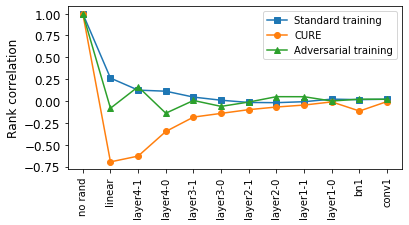

In [25]:
plt.figure(figsize=(6, 3))
plt.plot(spr_standard, label="Standard training", marker="s")
plt.plot(spr_cure, label="CURE", marker="o")
plt.plot(spr_adv_train, label="Adversarial training", marker="^")
plt.legend()
plt.xticks(range(12), ["no rand"] + layer_names[1:], rotation=90);
plt.yticks(fontsize=12)
plt.ylabel("Rank correlation", fontsize=12)
# plt.title("without absolute value")
plt.savefig("spr_cascade_randomized_cifar_no_abs.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05);

### Comparing gini index of different methods

In [34]:
def gini(array):

    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = np.array(array, dtype=np.float64)
    array = np.abs(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1, array.shape[0] + 1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n - 1) * array)) / (n * np.sum(array)))

In [39]:
# models
model_standard = ResNet18()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = ResNet18()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)
######
model_adv_train = ResNet18()
model_adv_train.load_state_dict(torch.load("models/RN18_linf_8_model_only.pt")["net"])
model_adv_train = model_adv_train.eval().to(device)
#################################
np.random.seed(seed=2)
torch.random.manual_seed(seed=2)
torch.cuda.random.manual_seed(seed=2)
dataiter = iter(test_loader)

gini_standard = []
gini_cure = []
gini_adv_train = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    images, labels = next(dataiter)
    a = np.random.randint(8)
    x = images[a].unsqueeze(0).to(device)
    idx = labels[a].to(device)
    #######
    expl_standard = get_expl(model_standard, x, "saliency", desired_index=idx).detach().cpu()
    expl_cure = get_expl(model_cure, x, "saliency", desired_index=idx).detach().cpu()
    expl_adv_train = get_expl(model_adv_train, x, "saliency", desired_index=idx).detach().cpu()
    #######
    gini_standard.append(gini(expl_standard.flatten()))
    gini_cure.append(gini(expl_cure.flatten()))
    gini_adv_train.append(gini(expl_adv_train.flatten()))
    del expl_standard
    del expl_cure
    del expl_adv_train
    torch.cuda.empty_cache()
    

0


/home/ubuntu/anaconda3/envs/pytorch_latest_p37/lib/python3.7/site-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


100
200
300
400
500
600
700
800
900


In [40]:
len(gini_standard)

1000

In [41]:
print("G(standard): {} +- {}".format(np.mean(gini_standard), np.std(gini_standard)) )
print("G(CURE): {} +- {}".format(np.mean(gini_cure), np.std(gini_cure)))
print("G(adversarial training): {} +- {}".format(np.mean(gini_adv_train), np.std(gini_adv_train)))

G(standard): 0.5410023248434214 +- 0.03546220410444776
G(CURE): 0.5371006980889339 +- 0.04559953101386771
G(adversarial training): 0.7122767814961151 +- 0.05388117407264482


In [1]:
nn.Softplus()

NameError: name 'nn' is not defined

### checker board examples

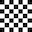

In [30]:
chess = Image.open("checkerboard32.png")
chess

In [35]:
x_chess = torchvision.transforms.ToTensor()(chess).unsqueeze(0).to(device)

In [38]:
x_chess = x_chess[:,0:3]

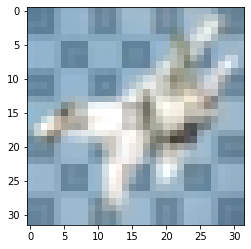

In [39]:
plt.imshow(torch_to_image(img+1*x_chess, data_mean, data_std))

In [40]:
# models
model_standard = resnet18_softplus()
model_standard.load_state_dict(torch.load("models/RN18_standard.pth")["net"])
model_standard = model_standard.eval().to(device)
######
model_cure = resnet18_softplus()
model_cure.load_state_dict(torch.load("models/RN18_CURE.pth")["net"])
model_cure = model_cure.eval().to(device)

In [41]:
model_standard(img).argmax()

tensor(0, device='cuda:0')

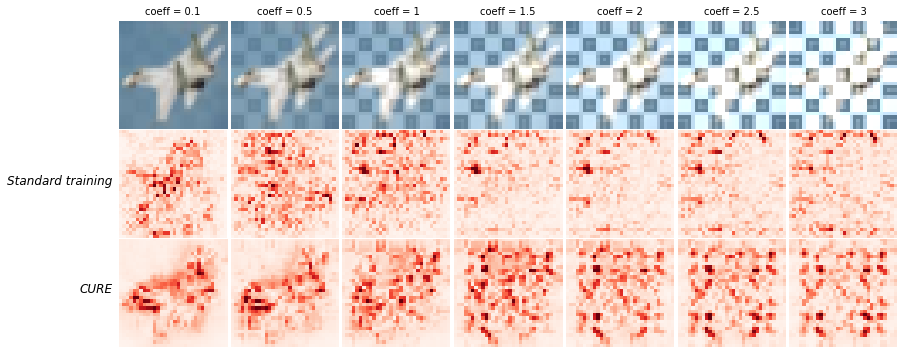

In [44]:
fig, ax = plt.subplots(3, 7, figsize=(14,6))
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].imshow(torch_to_image(img+c*x_chess, data_mean, data_std))
    expl_standard = get_expl(model_standard, img+c*x_chess, "saliency", desired_index=img_label)
    expl_cure = get_expl(model_cure, img+c*x_chess, "saliency", desired_index=img_label)
    viz.visualize_image_attr(np.transpose(expl_standard.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[1, i]), use_pyplot=False)

    viz.visualize_image_attr(np.transpose(expl_cure.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap="Reds",
                             show_colorbar=False,
                             outlier_perc=2,
                             fig_size=(4,4), plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)
    
    
for i, c in enumerate([0.1, 0.5, 1, 1.5, 2, 2.5, 3]):
    ax[0, i].set_title("coeff = {}".format(c), fontsize=10)
for i in range(3):
    for j in range(7):
        ax[i,j].axis('off')
fig.text(0.12, 0.5, 'Standard training', style = 'oblique', fontsize = 12, horizontalalignment ='right')
fig.text(0.12, 0.25, 'CURE', style = 'oblique', fontsize = 12, horizontalalignment ='right')
plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig("checkerboard_cifar.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)

### adding a small object to an image

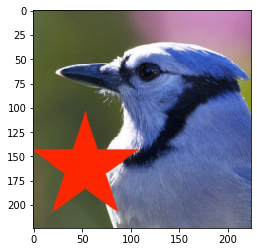

In [27]:
x_star = load_image(data_mean, data_std, device, "../sample_imagenet/sample_0_star.jpg")
plt.imshow(torch_to_image(x_star, data_mean, data_std))

In [28]:
model = torchvision.models.vgg16(pretrained=True).to(device)
model = model.eval()

In [29]:
model(x_star).argmax()

tensor(17, device='cuda:0')

/home/ubuntu/captum/captum/_utils/gradient.py:55: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


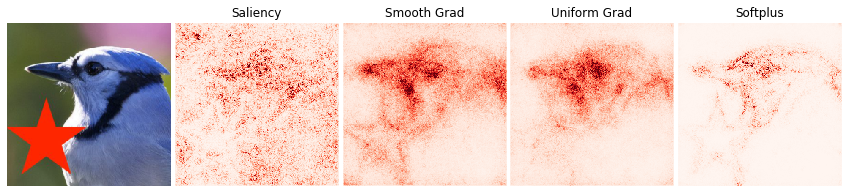

In [30]:
fig, ax = plt.subplots(1, 5, figsize=(15,3))
ax[0].imshow(torch_to_image(x_star, data_mean, data_std))

x_expl_grad = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_grad.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[1]), use_pyplot=False)
del x_expl_grad
torch.cuda.empty_cache()

x_expl_sg = get_expl(model, x_star, "saliency", desired_index=idx, smooth=True, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_sg.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[2]), use_pyplot=False)
del x_expl_sg
torch.cuda.empty_cache()

x_expl_ug = get_expl(model, x_star, "uniform_grad", desired_index=idx, sigma=sigma).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_ug.squeeze().cpu().detach().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[3]), use_pyplot=False)
del x_expl_ug
torch.cuda.empty_cache()

##########softplus###########
model = convert_relu_to_softplus(model, beta=0.8)
x_expl_softplus = get_expl(model, x_star, "saliency", desired_index=idx).detach().cpu()
viz.visualize_image_attr(np.transpose(x_expl_softplus.squeeze().numpy(), (1,2,0)),
                         np.transpose(x_star.squeeze().cpu().detach().numpy(), (1,2,0)),
                         method='heat_map',
                         cmap="Reds",
                         show_colorbar=False,
                         outlier_perc=2,
                         fig_size=(4,4), plt_fig_axis=(fig, ax[4]), use_pyplot=False)
del x_expl_softplus
torch.cuda.empty_cache()

ax[1].set_title("Saliency")
ax[2].set_title("Smooth Grad")
ax[3].set_title("Uniform Grad")
ax[4].set_title("Softplus")
plt.subplots_adjust(wspace=0.01, hspace=0.01)
for i in range(5):
    ax[i].axis('off')
plt.savefig("added_object_expl.jpg", dpi=300, bbox_inches='tight', pad_inches=0.05)